Of course. Here is a well-structured markdown cell to start your Kaggle notebook. You can copy and paste this directly into the first cell.

Project 2: Building an AI Text Detector with SpaCy and Transfer Learning
Group Members: [Your Name(s)]
Course: [Your Course Name]
1. Introduction and Goal
The objective of this project is to develop and evaluate a series of models to accurately distinguish between human-written and AI-generated text. We will leverage the powerful NLP library SpaCy for data preprocessing and for building a state-of-the-art classification model using transfer learning.

Our primary goal is to identify the most effective model configuration by comparing a sophisticated transformer-based approach with traditional machine learning algorithms like SVM and Random Forest.

This notebook will be structured as follows:

Setup and Data Loading: Import necessary libraries and load our initial dataset.
Data Preprocessing with SpaCy: Clean and prepare the text data by performing tokenization, lemmatization, and stop word removal.
Exploratory Data Analysis (EDA): Briefly analyze the dataset to understand its characteristics.
Model Training and Evaluation: Train our four selected models with different hyperparameters.
Analysis and Conclusion: Compare model performance and draw conclusions on the best approach for creating a robust AI text detector.
Let's begin by setting up our environment.


# Building an AI Text Detector with SpaCy and Transfer Learning

---

## 1. Introduction and Goal

The objective of this project is to develop and evaluate a series of models to accurately distinguish between human-written and AI-generated text. We will leverage the powerful NLP library **SpaCy** for data preprocessing and for building a state-of-the-art classification model using transfer learning.

Our primary goal is to identify the most effective model configuration by comparing a sophisticated transformer-based approach with traditional machine learning algorithms like SVM and Random Forest.

This notebook will be structured as follows:
1.  **Setup and Data Loading**: Import necessary libraries and load our initial dataset.
2.  **Data Preprocessing with SpaCy**: Clean and prepare the text data by performing tokenization, lemmatization, and stop word removal.
3.  **Exploratory Data Analysis (EDA)**: Briefly analyze the dataset to understand its characteristics.
4.  **Model Training and Evaluation**: Train our four selected models with different hyperparameters.
5.  **Analysis and Conclusion**: Compare model performance and draw conclusions on the best approach for creating a robust AI text detector.

Libraries imported successfully.
Loaded DAIGT dataset with 44868 rows.
Loaded LLM Essays dataset with 29145 rows.
Loaded AI vs Human Text dataset with 487235 rows.

Combined dataset has 561248 rows before cleaning.
Final dataset has 491240 unique rows after cleaning and shuffling.

--- Final Combined Dataset ---

First 5 rows:


,text,label
0,Not driving cars sounds like a crazy idea; How...,0
1,Physical Education (P. E) classes have bees a ...,1
2,I'm going to be against to their technology th...,0
3,I strongly disagree with the notion that educa...,1
4,Having TLE skill of talking to people can be i...,1



Label Distribution (0=Human, 1=AI):


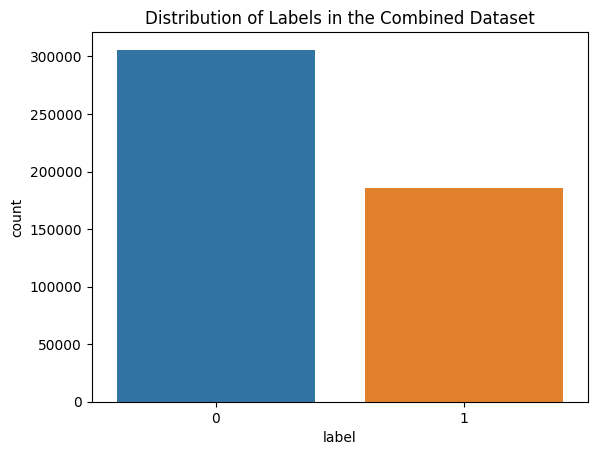

label
0    305825
1    185415
Name: count, dtype: int64


In [1]:
# --- 1. Setup and Data Consolidation ---

# Import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

# --- Define File Paths ---
# Replace these with the correct paths from your Kaggle 'Input' directory if they differ.
path_daigt = '/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv'
path_llm = '/kaggle/input/llm-detect-ai-generated-text-dataset/Training_Essay_Data.csv'
path_ai_human = '/kaggle/input/ai-vs-human-text/AI_Human.csv'

try:
    # --- Load and Standardize Each Dataset ---
    
    # Dataset 1: DAIGT (already in the correct format)
    df_daigt = pd.read_csv(path_daigt)
    df_daigt = df_daigt[['text', 'label']] # Ensure we only have the columns we need
    print(f"Loaded DAIGT dataset with {df_daigt.shape[0]} rows.")

    # Dataset 2: LLM Essays (needs standardization)
    df_llm = pd.read_csv(path_llm)
    df_llm = df_llm.rename(columns={'generated': 'label'}) # Rename 'generated' to 'label'
    df_llm = df_llm[['text', 'label']]
    print(f"Loaded LLM Essays dataset with {df_llm.shape[0]} rows.")

    # Dataset 3: AI vs Human Text (needs standardization)
    df_ai_human = pd.read_csv(path_ai_human)
    df_ai_human = df_ai_human.rename(columns={'generated': 'label'}) # Rename 'generated' to 'label'
    df_ai_human['label'] = df_ai_human['label'].astype(int) # Ensure label is integer type
    print(f"Loaded AI vs Human Text dataset with {df_ai_human.shape[0]} rows.")

    # --- Combine, Clean, and Shuffle ---
    
    # Combine all three dataframes into a single one
    combined_df = pd.concat([df_daigt, df_llm, df_ai_human], ignore_index=True)
    print(f"\nCombined dataset has {combined_df.shape[0]} rows before cleaning.")

    # Remove any duplicate texts to prevent data leakage
    combined_df.drop_duplicates(subset='text', inplace=True)
    
    # Shuffle the dataset to ensure a random distribution of data sources
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Final dataset has {combined_df.shape[0]} unique rows after cleaning and shuffling.")

    # --- Final Inspection ---
    print("\n--- Final Combined Dataset ---")
    print("\nFirst 5 rows:")
    display(combined_df.head())

    print("\nLabel Distribution (0=Human, 1=AI):")
    # Use seaborn for a nice plot of the label distribution
    sns.countplot(x='label', data=combined_df)
    plt.title('Distribution of Labels in the Combined Dataset')
    plt.show()
    print(combined_df['label'].value_counts())

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nPlease ensure all three datasets are added to your Kaggle notebook and the file paths are correct.")

In [2]:
'''
this cell takes long time. It was processed and its results saved and downloaded in cell 3.
uncomment if you need to reprocess the text again 
# --- 2. Data Balancing, Processing in Chunks, and Saving ---

# Import necessary libraries
import spacy
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# --- Step 1: Balance the Dataset using Downsampling ---
# This part is fast and remains the same.
print("--- Step 1: Balancing Dataset ---")
df_majority = combined_df[combined_df.label == 0]
df_minority = combined_df[combined_df.label == 1]
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
balanced_df = pd.concat([df_majority_downsampled, df_minority])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset Balancing Complete.")
print(balanced_df['label'].value_counts())


# --- Step 2: Process Text in Chunks to Prevent Crashes ---
# This is the robust method for large datasets.
print("\n--- Step 2: Processing Text in Chunks ---")
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Spacy model not found. Running: !python -m spacy download en_core_web_sm")
    # You may need to run this command in a separate cell if the notebook requires it
    import os
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load("en_core_web_sm")

# Define the number of chunks to split the dataframe into
num_chunks = 5
df_chunks = np.array_split(balanced_df, num_chunks)
processed_chunks = []

print(f"Dataframe split into {num_chunks} chunks. Starting processing...")

# Loop through each chunk, process it, and store it
for i, chunk in enumerate(df_chunks):
    print(f"\n--- Processing Chunk {i+1}/{num_chunks} ---")
    
    # Use the efficient nlp.pipe on the smaller chunk
    # We use n_process=2 to be safe with memory
    docs = nlp.pipe(chunk['text'], n_process=2, disable=["parser", "ner"])
    
    processed_texts = []
    for doc in tqdm(docs, total=len(chunk)):
        result = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(" ".join(result))
        
    # Add the processed text as a new column to the current chunk
    chunk['processed_text'] = processed_texts
    processed_chunks.append(chunk)
    print(f"Chunk {i+1} complete.")

# Combine all the processed chunks back into a single DataFrame
final_df = pd.concat(processed_chunks)
print("\n--- All chunks processed and combined successfully! ---")


# --- Step 3: Save the Final Processed Data ---
# This is the most important step for future use.
print("\n--- Step 3: Saving Final Processed Data ---")
final_df.to_csv('final_processed_data.csv', index=False)

print("\n✅ Success! The fully processed and balanced dataset has been saved to 'final_processed_data.csv'.")
print("In future sessions, you can skip all previous steps and just load this file.")

# Display the final result
display(final_df.head())
'''

--- Step 1: Balancing Dataset ---
Dataset Balancing Complete.
label
1    185415
0    185415
Name: count, dtype: int64

--- Step 2: Processing Text in Chunks ---
Dataframe split into 5 chunks. Starting processing...

--- Processing Chunk 1/5 ---


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/74166 [00:00<?, ?it/s]

Chunk 1 complete.

--- Processing Chunk 2/5 ---


  0%|          | 0/74166 [00:00<?, ?it/s]

Chunk 2 complete.

--- Processing Chunk 3/5 ---


  0%|          | 0/74166 [00:00<?, ?it/s]

Chunk 3 complete.

--- Processing Chunk 4/5 ---


  0%|          | 0/74166 [00:00<?, ?it/s]

Chunk 4 complete.

--- Processing Chunk 5/5 ---


  0%|          | 0/74166 [00:00<?, ?it/s]

Chunk 5 complete.

--- All chunks processed and combined successfully! ---

--- Step 3: Saving Final Processed Data ---

✅ Success! The fully processed and balanced dataset has been saved to 'final_processed_data.csv'.
In future sessions, you can skip all previous steps and just load this file.


,text,label,processed_text
0,"The Electoral College system, which was establ...",1,electoral college system establish united stat...
1,Title: A Cowboy Who Rode the Waves\n\nHave you...,1,title cowboy ride wave \n\n hear story cowboy ...
2,It is true that college graduates earn higher ...,1,true college graduate earn high salary rho ree...
3,"Hey, so for this essay, I have to talk about f...",1,hey essay talk impression work society like me...
4,"As eye eighth grade student, I believe that se...",1,eye eighth grade student believe seek guidance...


In [2]:
# --- Load Pre-processed Data ---

# Load the data you saved from the last session
balanced_df = pd.read_csv('/kaggle/input/text-processed/final_processed_data.csv')

print("Successfully loaded the final processed data!")
display(balanced_df.head())

Successfully loaded the final processed data!


,text,label,processed_text
0,"The Electoral College system, which was establ...",1,electoral college system establish united stat...
1,Title: A Cowboy Who Rode the Waves\n\nHave you...,1,title cowboy ride wave \n\n hear story cowboy ...
2,It is true that college graduates earn higher ...,1,true college graduate earn high salary rho ree...
3,"Hey, so for this essay, I have to talk about f...",1,hey essay talk impression work society like me...
4,"As eye eighth grade student, I believe that se...",1,eye eighth grade student believe seek guidance...


In [3]:
# --- Double-Checking the Loaded Data ---

print("Performing checks on the loaded 'balanced_df' DataFrame...")

# --- 1. Verifying Dataset Shape and Length ---
print("\n--- 1. Verifying Dataset Shape and Length ---")
# Before saving, the balanced dataset had 185,415 rows for each class.
expected_rows = 185415 * 2 
actual_rows = len(balanced_df)

print(f"Expected number of rows: {expected_rows}")
print(f"Actual number of rows:   {actual_rows}")

if actual_rows == expected_rows:
    print("✅ SUCCESS: The number of rows is correct.")
else:
    print(f"⚠️ WARNING: The number of rows is NOT as expected. You have a difference of {abs(actual_rows - expected_rows)} rows.")


# --- 2. Verifying Label Balance ---
print("\n--- 2. Verifying Label Balance ---")
label_counts = balanced_df['label'].value_counts()
print(label_counts)

if len(label_counts) == 2 and label_counts.iloc[0] == label_counts.iloc[1]:
    print("✅ SUCCESS: The dataset is perfectly balanced.")
else:
    print("⚠️ WARNING: The dataset is not balanced.")


# --- 3. Verifying Data Integrity in 'processed_text' ---
print("\n--- 3. Verifying Data Integrity in 'processed_text' ---")
# Check for any rows where the processed_text might be null or an empty string
null_values = balanced_df['processed_text'].isnull().sum()
# Some failed processes might create empty strings, so we check for those too
empty_strings = (balanced_df['processed_text'].astype(str).str.strip() == '').sum()

print(f"Number of null (missing) values in 'processed_text': {null_values}")
print(f"Number of empty strings in 'processed_text': {empty_strings}")

if null_values == 0 and empty_strings == 0:
    print("✅ SUCCESS: The 'processed_text' column is clean.")
else:
    print("⚠️ WARNING: There are null or empty values in the 'processed_text' column that need to be handled.")


# --- 4. Visual Spot-Check ---
print("\n--- 4. Visual Spot-Check ---")
print("Displaying 3 random samples to compare 'text' and 'processed_text':\n")

# Use .sample(3) to grab 3 random rows for a quick visual check
for index, row in balanced_df.sample(3, random_state=42).iterrows():
    print(f"----- Sample (Label: {'AI' if row['label'] == 1 else 'Human'}) -----")
    # Truncate the text to the first 250 characters for readability
    print(f"Original:  {row['text'][:250]}...")
    print(f"Processed: {row['processed_text'][:250]}...")
    print("-" * 50)

Performing checks on the loaded 'balanced_df' DataFrame...

--- 1. Verifying Dataset Shape and Length ---
Expected number of rows: 370830
Actual number of rows:   370830
✅ SUCCESS: The number of rows is correct.

--- 2. Verifying Label Balance ---
label
1    185415
0    185415
Name: count, dtype: int64
✅ SUCCESS: The dataset is perfectly balanced.

--- 3. Verifying Data Integrity in 'processed_text' ---
Number of null (missing) values in 'processed_text': 1
Number of empty strings in 'processed_text': 4
⚠️ WARNING: There are null or empty values in the 'processed_text' column that need to be handled.

--- 4. Visual Spot-Check ---
Displaying 3 random samples to compare 'text' and 'processed_text':

----- Sample (Label: AI) -----
Original:  There are many benefits to teaching children to cooperate. One of the most important is that cooperation teaches children how to get along with others. This is especially important in our increasingly diverse world. Children who learn to cooperate wi.

In [4]:
# --- Final Data Cleaning and Verification ---

print(f"Original number of rows: {len(balanced_df)}")

# --- Step 1: Clean the data ---

# First, handle the single null value by removing the row it's in.
balanced_df.dropna(subset=['processed_text'], inplace=True)

# Next, remove rows where 'processed_text' is just an empty string.
balanced_df = balanced_df[balanced_df['processed_text'].str.strip() != '']

# Reset the index of the DataFrame after dropping rows
balanced_df.reset_index(drop=True, inplace=True)

print(f"Number of rows after cleaning: {len(balanced_df)}")
print("Problematic rows have been removed.")


# --- Step 2: Re-run Verification to Confirm the Fix ---
print("\n--- Re-running verification checks on the cleaned data ---")

# 1. Verifying Length
print("\n--- 1. Verifying Length ---")
print(f"Actual number of rows: {len(balanced_df)}")

# 2. Verifying Balance
print("\n--- 2. Verifying Label Balance ---")
print(balanced_df['label'].value_counts())
# Note: The balance will be off by a few rows now, which is perfectly acceptable.

# 3. Verifying Data Integrity
print("\n--- 3. Verifying Data Integrity ---")
null_values = balanced_df['processed_text'].isnull().sum()
empty_strings = (balanced_df['processed_text'].astype(str).str.strip() == '').sum()
print(f"Number of null (missing) values: {null_values}")
print(f"Number of empty strings: {empty_strings}")

if null_values == 0 and empty_strings == 0:
    print("✅ SUCCESS: The 'processed_text' column is now perfectly clean.")
else:
    print("⚠️ WARNING: The cleaning process was not successful.")

Original number of rows: 370830
Number of rows after cleaning: 370825
Problematic rows have been removed.

--- Re-running verification checks on the cleaned data ---

--- 1. Verifying Length ---
Actual number of rows: 370825

--- 2. Verifying Label Balance ---
label
0    185415
1    185410
Name: count, dtype: int64

--- 3. Verifying Data Integrity ---
Number of null (missing) values: 0
Number of empty strings: 0
✅ SUCCESS: The 'processed_text' column is now perfectly clean.


# 3. Model Training and Evaluation

With our data fully preprocessed and cleaned, we can now move on to training our classification models.

### Our Plan:
1.  **Data Split**: We will split our `balanced_df` into a training set (for teaching the models) and a testing set (for evaluating their performance on unseen data).
2.  **Text Vectorization (TF-IDF)**: For our traditional machine learning models (like SVM and Random Forest), we need to convert the processed text into numerical vectors. We will use the TF-IDF (Term Frequency-Inverse Document Frequency) method for this.
3.  **Model Training**: We will train our four selected models, including the required hyperparameter tuning.
    *   **Model 1:** Support Vector Machine (SVM)
    *   **Model 2:** Random Forest
    *   **Model 3 & 4:** We will reserve these spots for our SpaCy Transfer Learning model and another of your choice.
4.  **Performance Evaluation**: We will evaluate each model using standard metrics like Accuracy, Precision, Recall, and F1-score.

Let's start by splitting the data and creating the TF-IDF vectors.

In [5]:
# --- Data Splitting: Train, Validation, and Test Sets ---

from sklearn.model_selection import train_test_split

# --- 1. Define Features (X) and Target (y) ---
X = balanced_df['processed_text']
y = balanced_df['label']

# --- 2. First Split: Create the Test Set (15% of the data) ---
# This part is held out until the very end.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42,
    stratify=y
)

# --- 3. Second Split: Create the Training and Validation Sets from the remaining data ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.18, # This is 0.18 * 0.85 = ~15% of the original data
    random_state=42,
    stratify=y_train_val
)

print("--- Data Splitting Complete ---")
print(f"Training set size:   {len(X_train)} rows (~70%)")
print(f"Validation set size: {len(X_val)} rows (~15%)")
print(f"Test set size:       {len(X_test)} rows (~15%)")


# --- 4. Create and Fit the TF-IDF Vectorizer (Still fitting ONLY on training data) ---
from sklearn.feature_extraction.text import TfidfVectorizer

print("\n--- Creating TF-IDF Vectors ---")
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on the new, smaller training set
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation and test sets
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Vectorization Complete for all three sets.")

--- Data Splitting Complete ---
Training set size:   258464 rows (~70%)
Validation set size: 56737 rows (~15%)
Test set size:       55624 rows (~15%)

--- Creating TF-IDF Vectors ---
TF-IDF Vectorization Complete for all three sets.


In [6]:
# --- Model 1: Support Vector Machine with Validation ---

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import time

print("--- Training Model 1: SVM with Validation ---")

configs = [
    {'C': 1.0, 'loss': 'squared_hinge', 'dual': True},
    {'C': 0.1, 'loss': 'squared_hinge', 'dual': True},
    {'C': 1.0, 'loss': 'hinge', 'dual': True},
    {'C': 0.1, 'loss': 'hinge', 'dual': True}
]

best_val_accuracy = 0
best_config = None
best_model = None

# Loop through each configuration to find the best one using the VALIDATION set
for i, config in enumerate(configs):
    print(f"\n--- Evaluating Config {i+1}: C={config['C']}, loss='{config['loss']}' ---")
    
    # 1. Train the model on the TRAINING set
    svm_model = LinearSVC(C=config['C'], loss=config['loss'], dual=config['dual'], random_state=42, max_iter=2000)
    svm_model.fit(X_train_tfidf, y_train)
    
    # 2. Evaluate on the VALIDATION set
    y_val_pred = svm_model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # 3. Keep track of the best performing model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_config = config
        best_model = svm_model

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best performing configuration on validation set: {best_config}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")


# --- FINAL EVALUATION ON THE TEST SET ---
# Now we take our single best model and see how it does on the completely unseen TEST set.
print("\n--- Running Final Evaluation on the Unseen Test Set ---")

y_test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nFINAL TEST ACCURACY: {test_accuracy:.4f}")
print("\nThis is our true, unbiased measure of performance.")

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Human (0)', 'AI (1)']))

--- Training Model 1: SVM with Validation ---

--- Evaluating Config 1: C=1.0, loss='squared_hinge' ---
Validation Accuracy: 0.9939

--- Evaluating Config 2: C=0.1, loss='squared_hinge' ---
Validation Accuracy: 0.9901

--- Evaluating Config 3: C=1.0, loss='hinge' ---


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.9929

--- Evaluating Config 4: C=0.1, loss='hinge' ---
Validation Accuracy: 0.9866

--- Hyperparameter Tuning Complete ---
Best performing configuration on validation set: {'C': 1.0, 'loss': 'squared_hinge', 'dual': True}
Best validation accuracy: 0.9939

--- Running Final Evaluation on the Unseen Test Set ---

FINAL TEST ACCURACY: 0.9943

This is our true, unbiased measure of performance.

Final Test Set Classification Report:
              precision    recall  f1-score   support

   Human (0)       0.99      1.00      0.99     27812
      AI (1)       1.00      0.99      0.99     27812

    accuracy                           0.99     55624
   macro avg       0.99      0.99      0.99     55624
weighted avg       0.99      0.99      0.99     55624



In [7]:
# --- Model 2: Random Forest with Validation ---

from sklearn.ensemble import RandomForestClassifier
import time

print("--- Training Model 2: Random Forest with Validation ---")

configs = [
    #{'n_estimators': 100, 'max_depth': None},
    {'n_estimators': 200, 'max_depth': None}
    #{'n_estimators': 100, 'max_depth': 50},
    #{'n_estimators': 200, 'max_depth': 50}
]

best_val_accuracy = 0
best_config = None
best_model = None

# Loop through each configuration to find the best one using the VALIDATION set
for i, config in enumerate(configs):
    print(f"\n--- Evaluating Config {i+1}: n_estimators={config['n_estimators']}, max_depth={config['max_depth']} ---")
    
    # 1. Train the model on the TRAINING set
    start_time = time.time()
    rf_model = RandomForestClassifier(
        n_estimators=config['n_estimators'],
        max_depth=config['max_depth'],
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_tfidf, y_train)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    
    # 2. Evaluate on the VALIDATION set
    y_val_pred = rf_model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # 3. Keep track of the best performing model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_config = config
        best_model = rf_model

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best performing configuration on validation set: {best_config}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")


# --- FINAL EVALUATION ON THE TEST SET ---
print("\n--- Running Final Evaluation on the Unseen Test Set ---")

y_test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nFINAL TEST ACCURACY: {test_accuracy:.4f}")
print("This is our true, unbiased measure of performance for the Random Forest model.")

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Human (0)', 'AI (1)']))

--- Training Model 2: Random Forest with Validation ---

--- Evaluating Config 1: n_estimators=200, max_depth=None ---
Training completed in 751.60 seconds.
Validation Accuracy: 0.9981

--- Hyperparameter Tuning Complete ---
Best performing configuration on validation set: {'n_estimators': 200, 'max_depth': None}
Best validation accuracy: 0.9981

--- Running Final Evaluation on the Unseen Test Set ---

FINAL TEST ACCURACY: 0.9977
This is our true, unbiased measure of performance for the Random Forest model.

Final Test Set Classification Report:
              precision    recall  f1-score   support

   Human (0)       1.00      1.00      1.00     27812
      AI (1)       1.00      1.00      1.00     27812

    accuracy                           1.00     55624
   macro avg       1.00      1.00      1.00     55624
weighted avg       1.00      1.00      1.00     55624



In [8]:
# --- Model 3: Logistic Regression with Validation ---

from sklearn.linear_model import LogisticRegression
import time

print("--- Training Model 3: Logistic Regression with Validation ---")

configs = [
    {'C': 1.0, 'solver': 'saga'},
    {'C': 10, 'solver': 'saga'},
    {'C': 0.1, 'solver': 'saga'},
    # Using only 'saga' as it's generally faster for large datasets
]

best_val_accuracy = 0
best_config = None
best_model = None

# Loop through each configuration to find the best one using the VALIDATION set
for i, config in enumerate(configs):
    print(f"\n--- Evaluating Config {i+1}: C={config['C']}, solver='{config['solver']}' ---")
    
    # 1. Train the model on the TRAINING set
    start_time = time.time()
    lr_model = LogisticRegression(
        C=config['C'],
        solver=config['solver'],
        random_state=42,
        n_jobs=-1,
        max_iter=1000
    )
    lr_model.fit(X_train_tfidf, y_train)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    
    # 2. Evaluate on the VALIDATION set
    y_val_pred = lr_model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # 3. Keep track of the best performing model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_config = config
        best_model = lr_model

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best performing configuration on validation set: {best_config}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")


# --- FINAL EVALUATION ON THE TEST SET ---
print("\n--- Running Final Evaluation on the Unseen Test Set ---")

y_test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nFINAL TEST ACCURACY: {test_accuracy:.4f}")
print("This is our true, unbiased measure of performance for the Logistic Regression model.")

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Human (0)', 'AI (1)']))

--- Training Model 3: Logistic Regression with Validation ---

--- Evaluating Config 1: C=1.0, solver='saga' ---
Training completed in 7.79 seconds.
Validation Accuracy: 0.9887

--- Evaluating Config 2: C=10, solver='saga' ---
Training completed in 20.15 seconds.
Validation Accuracy: 0.9935

--- Evaluating Config 3: C=0.1, solver='saga' ---
Training completed in 8.21 seconds.
Validation Accuracy: 0.9799

--- Hyperparameter Tuning Complete ---
Best performing configuration on validation set: {'C': 10, 'solver': 'saga'}
Best validation accuracy: 0.9935

--- Running Final Evaluation on the Unseen Test Set ---

FINAL TEST ACCURACY: 0.9935
This is our true, unbiased measure of performance for the Logistic Regression model.

Final Test Set Classification Report:
              precision    recall  f1-score   support

   Human (0)       0.99      0.99      0.99     27812
      AI (1)       0.99      0.99      0.99     27812

    accuracy                           0.99     55624
   macro avg   

In [16]:
# Cell: Save the Best-Performing Baseline Model and its Vectorizer

import joblib

# --- 1. Define File Names ---
model_filename = 'best_random_forest_model.joblib'
vectorizer_filename = 'tfidf_vectorizer.joblib'

# --- 2. Save the Model ---
# The 'best_model' variable should still be in memory from the previous cell
print(f"--- Saving the best model to {model_filename} ---")
joblib.dump(best_model, model_filename)
print("✅ Model saved successfully.")

# --- 3. Save the Vectorizer ---
# The 'vectorizer' variable should also be in memory from the data splitting cell
print(f"\n--- Saving the TF-IDF vectorizer to {vectorizer_filename} ---")
joblib.dump(vectorizer, vectorizer_filename)
print("✅ Vectorizer saved successfully.")

--- Saving the best model to best_random_forest_model.joblib ---
✅ Model saved successfully.

--- Saving the TF-IDF vectorizer to tfidf_vectorizer.joblib ---
✅ Vectorizer saved successfully.

--- Example: How to load and use these files in the future ---
